# Data Preparation Part 1 (10 points)


Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

## Library Imports

In [1]:
# Base Imports
import pandas as pd
import numpy as np 
import time
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
%matplotlib inline

# Pre-Processing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Metrics and Evaluation
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

# Train/ Test Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

# Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import make_pipeline, Pipeline

# Estimators
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Hyper Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# T-Tests
from mlxtend.evaluate import paired_ttest_5x2cv


## Load Data

In [2]:
df = pd.read_csv('../../../data/cardio_train.csv', delimiter=';')
# set id as index
df.set_index("id", inplace=True)
# copy original data
df_clean = df.copy(deep=True)
# drop duplicates
df_clean.drop_duplicates(inplace=True)

## Apply Transformations

In [3]:
# %%time

# Convert age into years
df_clean['age'] = (df_clean['age'] / 365).round().astype('int')

# re-encode gender to male (1) and female (0)
df_clean['gender'] = np.where((df_clean.gender == 2), 1, 0)

# compute the body mass index based on weight and height
df_clean['bmi'] = df_clean['weight'] / (df_clean['height']/100)**2

# create a BMI group
df_clean['bmiGrp'] = np.where((df_clean.bmi < 18.5), 1, 0)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 18.5) & (df_clean.bmi < 25), 2, df_clean.bmiGrp)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 25) & (df_clean.bmi < 30), 3, df_clean.bmiGrp)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 30), 4, df_clean.bmiGrp)

# bin blood pressure groups based on the api hi/ lo variables
df_clean['bp'] = np.where((df_clean.ap_hi < 120) & (df_clean.ap_lo < 80), 1, 0)
df_clean['bp'] = np.where((df_clean.ap_hi >= 120) & (df_clean.ap_hi < 130) & (df_clean.ap_lo < 80), 2, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi >= 130) & (df_clean.ap_hi < 140) | ((df_clean.ap_lo >= 80) & (df_clean.ap_lo < 90)), 3, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi >= 140) | (df_clean.ap_lo >= 90), 4, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi > 180) | (df_clean.ap_lo > 120), 5, df_clean.bp)



This notebook uses two datasets, a cardiovascular dataset and a smoking dataset.  Each dataset is derived from the same data.  This data was uploaded to the Kaggle website by Svetlana Ulianova, who appears to be a data science student at Ryerson University.  Ms. Ulianova did not provide a source, or exact purpose of the dataset.  Further, Ms. Ulianova did not sponsor a competition or add a description with the dataset.  The data provided on Kaggle includes 70,000 rows and 12 different features, including whether a patient has cardiovascular disease and if a patient is a smoker.

The response variable in the cardiovascular dataset is whether a person has cardiovascular disease, which is denoted in the dataset as the attribute “cardio.”  The response variable in the smoking dataset is whether a person is a smoker, which is denoted in the dataset as the attribute “smoke.”  The analysis provides a prediction of whether a person has the presence or absence of cardiovascular disease, which is indicated by a column in the cardiovascular disease dataset titled “cardio,” and whether a person is or is not smoker, which is indicated by a column in the smoking dataset titled “smoke.”  The “cardio” and “smoke” columns in each of the cardiovascular disease and smoking datasets are binary, categorical variables. Therefore, the modeling problem for each of the cardiovascular disease and smoking datasets is defined as a classification problem. An effective outcome may be measured using the receiver operating characteristic and recall metrics, discussed below in more detail.

This notebook develops models to predict whether a person has cardiovascular disease and whether a person is a smoker based on the available data.  Therefore, the class variables are “Cardiovascular Disease” and “Smoking.”  Both class variables “Cardiovascular Disease” and “Smoking” are binary, categorical variables.  Further variable representations can be seen below in Table 1.  

**Table 1: Cardiovascular Dataset - Attribute Descriptions**

| Column Description | Feature Type | Column Name | Data Type |
|:---|:---|:---|:---|
| **Age**                        | Objective | age | int (days) |
| **Height**                     | Objective | height | int (cm) |
| **Weight**                     | Objective | weight | float (kg) |
| **Gender**                     | Objective | gender | 0: female, 1: male |
| **Systolic blood pressure**    | Examination | ap_hi | int |
| **Diastolic blood pressure**   | Examination | ap_lo | int |
| **Cholesterol**                | Examination | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| **Glucose**                    | Examination | gluc | 1: normal, 2: above normal, 3: well above normal |
| **Smoking**                    | Subjective | smoke | binary |
| **Alcohol intake**             | Subjective | alco | binary |
| **Physical activity**          | Subjective | active | binary |
| **Has CVD?**                   | Target | cardio | binary |

As can be seen in Table 1, the datasets used for classifying whether a person has cardiovascular disease, and if a person is a smoker use 11 features and 1 target variable, being having cardiovascular disease for the cardiovascular disease dataset and is a smoker for the smoking dataset, respectively. 



The 11 features represent three different types of input features.  These include objective features having factual information, examination features having medical examination information, and subjective features having patient response information.  Further, the datasets each include 70,000 rows used in each of the cardiovascular disease dataset and the smoking dataset.  To examine and provide classification of the presence of cardiovascular disease and whether a person is a smoker, relationships between each of the features using all of the rows by imputing, scaling, or one-hot encoding, values using a median or mean value for those that are missing.

Certain pre-processing techniques are used to prepare both the cardiovascular disease and smoking datasets.  These pre-processing methods use a variety of libraries used for data analysis in Python.  The libraries used for pre-processing include the “RobustScaler,” “StandardScaler,” “OneHotEncoder,” “SimpleImputer,” and “ColumnTransformer” functions within the scikit-learn package.  Specifically, the “RobustScaler,” “StandardScaler,” and “OneHotEncoder” functions are used in the “preprocessing” component of the scikit-learn package while the “SimpleImputer,” and “ColumnTransformer” are used in the “impute” and “compose” components of the scikit-learn package, respectively.  The RobustScaler() function from the scikit-learn python package is used to standardize values between features.  The RobustScaler() function scales features using statistical analysis that is robust to outliers in a dataset.  (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html).  A variety of different parameters may be adjusted to improve performance of each of the models.  For example, instead of using the RobustScaler() function, the StandardScalar() function may be implemented from the scikit-learn python package.  The StandardScalar() function removes the mean and scales to a unit variance to standardize the data. 
(https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).  
While not explicitly included in the preprocessing cell, these functions are implemented in a pipeline in later cells.


A one-hot encoding (OHE) has been implemented to standardize attributes such as gender and cholesterol.  However, since these categorical attributes were recorded as numerical variables when recorded into the dataset, OHE is not expected to impact the performance of the classifiers.  For example, gender was recorded as between 1 or 2 instead of 0 and 1, which is still indicative of an ordinal relationship.  Therefore, OHE may aid in standardizing the data, but in this instance, not impact performance of the models because of the encoding that occurred when the data were recorded.  Stated sufficiently, OHE may be redundant.

Initially, the data is loaded into a Python dataframe “df,” which is then copied into another Python dataframe “df_clean.”  Duplicates are dropped in the “df_clean” dataframe.  Next, the variable “age,” which is an integer in days, is converted into years while maintaining the type “int” for the “age” variable.  The categorical variable “gender” was originally encoded as being between “1” and “2.”  For consistency and clarity of interpretation, the “gender” variable was reencoded to define the input “male” as “1” and “female” as “0” as described.  

Feature engineering is also performed using the “height” and “weight” variables.  The variable “height” is an integer while the variable “weight” is a float.  Generally, the height and weight of an individual are related through the “Body Mass Index” (BMI) such that the weight divided by the squared quantity of height divided by 100 provides an indication of the BMI of a person.  Both the cardiovascular disease and smoking datasets use the “height” and “weight” variables provided to calculate and use BMI as a variable in the cardiovascular disease and smoking datasets.  Further, after the BMI is calculated for each dataset, the BMI is grouped based on resulting numerical, BMI values.  The BMI values are separated into 4 categories based on the BMI value calculated.  A new variable “bmiGrp” is used to separate the 4 new categories of BMI.  Specifically, a BMI value being less than 18.5 is represented as “1” in the “bmiGrp” variable, a BMI value being between 18.5 and 25 is represented as “2” in the “bmiGrp” variable, a BMI value between 25 and 30 is represented as “3” in the “bmiGrp” variable, and a BMI value being greater than 30 is represented as “4” in the “bmiGrp” variable.  Binning the BMI variable may provide greater indication of whether a person has cardiovascular disease or is a smoker by allowing for an analysis of potential separation of the groups.  For example, through comparing those who have cardiovascular disease and are smokers across groups, prediction accuracy my improve based on separation between groups.

Similarly, the variables “ap_hi” and “ap_lo” represent systolic and diastolic blood pressure, respectively.  Both variables are represented as integers.  The variables are combined and binned into a single variable representing blood pressure.  Specifically, the “ap_hi” and “ap-lo” variables are combined into a new variable labeled “bp” and binned into 5 distinct categories.  Specifically, the “bp” variable includes a category represented by “1” that divides blood pressure such that the “ap_hi” variable is less than 120 and the “ap_lo” variable is less than 80, a category represented by “2” that divides blood pressure such that the “ap_hi” variable is between 120 and 130 and the “ap_lo” variable is less than 80, a category represented by “3” that divides blood pressure such that the “ap_hi” variable is between 130 and 140 and the “ap_lo” variable is between 80 and 90,
a category represented by “4” that divides blood pressure such that the “ap_hi” variable is greater than or equal to 140 or the “ap_lo” variable greater than or equal to 90, and a category represented by “5” that divides blood pressure such that the “ap_hi” variable is greater than 180 or the “ap_lo” variable is greater than 120.


# Data Preparation Part 2 (5 points)


Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

There are two, final datasets, a cardiovascular dataset and a smoking dataset.  The response variable in the cardiovascular dataset is whether a person has cardiovascular disease, which is denoted in the dataset as the attribute “cardio.”  The response variable in the smoking dataset is whether a person is a smoker, which is denoted in the dataset as the attribute “smoke.”  The analysis provides a prediction of whether a person has the presence or absence of cardiovascular disease, which is indicated by a column in the cardiovascular disease dataset titled “cardio,” and whether a person is or is not smoker, which is indicated by a column in the smoking dataset titled “smoke.”  The “cardio” and “smoke” columns in each of the cardiovascular disease and smoking datasets are binary, categorical variables. Therefore, the modeling problem for each of the cardiovascular disease and smoking datasets is defined as a classification problem. An effective outcome may be measured using the receiver operating characteristic and recall metrics, discussed below in more detail.

With the variables created and categorized, the final dataset used for classifying the presence of cardiovascular disease includes columns “age,” “gender,” “bmiGrp,” “bp,” “cholesterol,” “gluc,” “smoke,” “alco,” and “active.”  Similarly, the final dataset used for classifying whether a person is a smoker includes columns “age,” “gender,” “bmiGrp,” “bp,” “cholesterol,” “gluc,” “cardio,” “alco,” and “active.”  The cardiovascular disease dataset has 9 attributes that are used to classify the response variable of “cardio” indicative of having cardiovascular disease.  The smoking dataset also has 9 attributes that are used to classify the response variable of “smoke” indicative of whether a person is a smoker.  Both the cardiovascular disease and smoking datasets use all the rows from the original dataset, or 70,000.

As discussed above, variables “bp” and “bmiGrp” are newly formed variables used in the analysis of the cardiovascular disease and smoking datasets.  The “bp” variable combines the “ap_hi” and “ap_lo” variables into a single category based on individual values in each of those attributes.  This allows for an analysis of whether a combined blood pressure may be indicative of cardiovascular disease by examining and comparing the categories.  A similar analysis is used to analyze whether a combined blood pressure may be indicative of smoking.  The newly formed “bmiGrp” is based on a calculated BMI value from the listed height and weight of each row that was recorded for each of the cardiovascular disease and smoking datasets.  Again, the “bmiGrp” bins rows into categories based on the calculated values.  This also allows for an analysis of whether a BMI above a threshold is indicative of cardiovascular disease.  Similarly, the “bmiGrp” variable provides an analysis of whether BMI being above a threshold is indicative of a person being a smoker.  Each of the “bmiGrp” and “bp” variables use all of the rows in each of the cardiovascular disease and smoking datasets.

In [4]:

# Store feature matrix for different tasks (has CVD) and (is smoker)
X_cols_cvd = ['age', 'gender', 'bmiGrp', 'bp', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
X_cols_smk = ['age', 'gender', 'bmiGrp', 'bp', 'cholesterol', 'gluc', 'cardio', 'alco', 'active']

X_cvd = df_clean[X_cols_cvd]
X_smk = df_clean[X_cols_smk]

y_cardio = df_clean['cardio']
y_smoke = df_clean['smoke']



In [5]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69976 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69976 non-null  int32  
 1   gender       69976 non-null  int32  
 2   height       69976 non-null  int64  
 3   weight       69976 non-null  float64
 4   ap_hi        69976 non-null  int64  
 5   ap_lo        69976 non-null  int64  
 6   cholesterol  69976 non-null  int64  
 7   gluc         69976 non-null  int64  
 8   smoke        69976 non-null  int64  
 9   alco         69976 non-null  int64  
 10  active       69976 non-null  int64  
 11  cardio       69976 non-null  int64  
 12  bmi          69976 non-null  float64
 13  bmiGrp       69976 non-null  int32  
 14  bp           69976 non-null  int32  
dtypes: float64(2), int32(4), int64(9)
memory usage: 7.5 MB


# Modeling and Evaluation 1 (10 points)


Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.



The response variable in the cardiovascular dataset is whether a person has cardiovascular disease, which is denoted in the dataset as the attribute “cardio.”  The analysis provides a prediction of whether a person has the presence or absence of cardiovascular disease, which is indicated by a column in the cardiovascular disease dataset titled “cardio.”  The “cardio” column of the cardiovascular disease dataset is a binary, categorical variable. Therefore, the modeling problem for the cardiovascular disease dataset is defined as a classification problem. Since the response variable, cardiovascular disease, is balanced, an effective outcome may be measured using the receiver operating characteristic metric, discussed below in more detail.

The cardiovascular disease dataset uses the receiver operating characteristic (“ROC”) metric to evaluate performance of the classification models.  The ROC metric characterizes a trade-off between true and false positives in a classification model.  Here, the ROC metric is used as a threshold related to the accuracy of the classification model used for cardiovascular disease.  The ROC graph compares a curve of false positives by true positives against a straight, diagonal line indicative of random guessing.  The area under the curve compared against the diagonal line is indicative of performance of the classification model.  For example, a model having greater area under the curve closer to the origin provides better classification accuracy for small false-positive rates, whereas a model having greater area under the curve further away from the origin, closer to 1 provides better classification accuracy for larger false-positive rates.  The false-positive rate is equal to the false-positive values divided by the total number of negative values.  Likewise, the true-positive rate is equal to the true-positive values divided by the total number of positive values.  

The ROC metric is appropriate to analyze the classification models on the cardiovascular disease dataset because the cardiovascular disease dataset is a balanced response variable, in this case cardiovascular disease.  Stated differently, the response variable, being cardiovascular disease has a high number of values being indicative of a lot of people having cardiovascular disease, and, therefore, the ROC metric provides a robust metric for evaluating performance of a model using the false-positive rates of each of the models.  The ROC metric provides an easily interpretable and visual metric to evaluate the performance of the classification models.  Further, in the instance of predicting the presence of cardiovascular disease, the false-positive rate is an important metric to evaluate.  For example, treating cardiovascular disease when no cardiovascular disease is present, a false-positive, is harmful to an otherwise healthy patient.  Stated differently, a patient that undergoes a surgical intervention without having cardiovascular disease is subjected to significant, unnecessary trauma.  In the absence of a surgical intervention, a healthy patient taking medication unnecessarily still provides harm to the patient, such as through side effects and secondary reactions to medications.  Therefore, when evaluating models designed to predict the presence of cardiovascular disease, the ROC metric and curve provides a method to analyze which models have the lowest false-positive rates when predicting the presence of cardiovascular disease.

The response variable in the smoking dataset is whether a person is a smoker, which is denoted in the dataset as the attribute “smoke.” The analysis provides a prediction of whether a person is or is not smoker, which is indicated by a column in the smoking dataset titled “smoke.”  The “smoke” column of the smoking dataset is a binary, categorical variable. Therefore, the modeling problem for the smoking dataset is defined as a classification problem. Since the smoking dataset is not balanced, an effective outcome may be measured using the recall metric, discussed below in more detail.

The smoking dataset uses the recall metric to evaluate performance of the classification models.  Again, the response variable, being whether a person smokes, is imbalanced, which implies that there are very few smokers included in the dataset.  This low amount of values representing smokers makes the ROC curve and metric unsuitable for model performance evaluation.  The recall metric provides an indication of the false negatives in the classification performance of the model.  Recall is a cost-sensitive measure used to analyze performance of a classification model based on the false negatives predicted from the model.  Specifically, recall is equal to the total true-positive predictions divided by the total quantity of the true-positive predictions added to the total false-negative values from the predictions of the classification models.  When evaluating the recall metric, the higher the recall value, less false-negative values are present in the prediction.  

The recall metric is appropriate to analyze the classification models on the smoking dataset because the smoking dataset has an imbalanced response variable, in this case smoking.  Stated differently, the response variable, being smoking has a low number of values being indicative of very few people being smokers, and, therefore, the recall metric provides a robust metric for evaluating performance of a model using the false-negative rates of each of the models.  The recall metric provides an easily interpretable metric to evaluate the performance of the classification models such that the higher recall value, the lower number of false negatives are being predicted.  Further, in the instance of predicting whether a person is a smoker, the false-negative rate is an important metric to evaluate.  For example, when determining whether a person is a smoker, such as during a health insurance premium determination, reducing the false-negative values, that is smokers predicted as not smokers is valuable.  Stated differently, a person who smokes presents a higher risk for needing long-term hospital care based on the damage to the lungs from the smoking.  Being at higher risk for expensive, future medical bills, a health insurance company may charge higher premiums to offset this voluntary risk.  Predicting someone as not a smoker when they do smoke, a false-negative, increases the risk that the health insurance company will need to pay for expensive medical bills without having recovered some of the losses with higher premiums.  Therefore, when evaluating models designed to predict whether a person is a smoker, the recall metric provides a method to analyze which models have the lowest false-negative rates when predicting if a person is a smoker.

To account for the imbalance in the smoking dataset, the “imbalanced-learn” Python package may be used to up sample the smoking dataset.  Specifically, using the “Pipeline” and “SMOTE” functions from the “pipeline” and “over_sampling” libraries, respectively.  This up sampling of the smoking dataset response variable allows the smoking dataset to also be evaluated using the ROC metric, as above described.  The ROC metric in the smoking dataset measures the false-positive rate of the response variable, or in this instance, a measure of the predictions of those who do not smoke as those who do smoke.  In the example provided, this would cause a person who is not a smoker to incur costs of someone who does smoke, which causes unnecessary expenses on those people labeled smokers who are not smokers.  Therefore, in order to reduce this type of error, the ROC metric is appropriate to evaluate models run on the smoking dataset, after the smoking dataset is up sampled, as described.

# Modeling and Evaluation 2 (10 points)

Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.




The response variable in the cardiovascular dataset is whether a person has cardiovascular disease, which is denoted in the dataset as the attribute “cardio.”  The analysis provides a prediction of whether a person has the presence or absence of cardiovascular disease, which is indicated by a column in the cardiovascular disease dataset titled “cardio.”  The “cardio” column of the cardiovascular disease dataset is a binary, categorical variable. Therefore, the modeling problem for the cardiovascular disease dataset is defined as a classification problem. Since the response variable, cardiovascular disease, is balanced, stratified cross-validation is used to divide the cardiovascular disease dataset.

The method used to divide the data into training and testing splits is stratified cross-validation.  Specifically, the method used is a 10-fold, stratified cross-validation with an 80/20 training/testing split.  Generally, cross-validation partitions data into a number of disjoint subsets.  The number of folds, in this instance 10, represents the number of disjoint subsets.  For example, a 10-fold cross validation trains on (10-1), or 9, partitions with testing being done the remaining partition.  Training the classifier using 9 partitions allows for separation between the testing and training data such that the classifier does not train on the testing data.  Keeping the testing data separate from the training data ensures that the metrics used to evaluate each of the classifiers for the cardiovascular disease dataset provide an accurate indication of performance of the model.  This is why the cardiovascular disease dataset uses an 80/20 split, being indicative of 80% of the data being used for training and 20% of the data being separated for testing.  As stated, however, the cardiovascular disease dataset uses stratified cross validation to split the testing and training data.  

Stratified cross validation uses two different classes having the same frequency in each fold of the cross validation.  This typically occurs after 10 folds in stratified cross validation, and thus the number of folds used with the cardiovascular disease dataset is set to 10.  Therefore, the method used to divide the cardiovascular disease dataset is a 10-fold, stratified cross validation.

The 10-fold, stratified cross validation is appropriate for the cardiovascular disease dataset because the 10-fold, stratified cross validation ensures an equal amount of positive and negative classes that occur with the same frequency, as described.  Since, as discussed above, the important metric for analysis with the cardiovascular disease dataset is the false-positive rate, having an equal distribution of positive and negative classes ensures that the false-positive rate, as evaluated by the ROC metric and curve, is not skewed.  For example, with very people having cardiovascular disease, or with very many people with cardiovascular disease, a number of false positives may appear to have a higher or lower rate due to the imbalance in the data.  Since the 10-fold, stratified cross validation ensures the same frequency between positive and negative classes, the false-positive rate is normalized. 

The response variable in the smoking dataset is whether a person is a smoker, which is denoted in the dataset as the attribute “smoke.” The analysis provides a prediction of whether a person is or is not smoker, which is indicated by a column in the smoking dataset titled “smoke.”  The “smoke” column of the smoking dataset is a binary, categorical variable. Therefore, the modeling problem for the smoking dataset is defined as a classification problem. Since the smoking dataset is not balanced, an effective method for dividing the smoking dataset is again the 10-fold, stratified cross validation using an 80/20 training/testing split of the smoking dataset.

As described in explicit detail above, the 10-fold stratified cross validation method provides a balance between positive and negative classes.  Here, the response variable of whether a person is a smoker, has an imbalance in the data.  Stated differently, the smoking dataset includes very few smokers.  This skews the data and as such, the recall metric being used to evaluate the models since a few false-negative values that occur with an imbalanced dataset skews the rate of occurrence of the false-negative values found the model.  Therefore, to account for this imbalance on the response variable in the smoking dataset, the 10-fold, stratified cross validation is used to eliminate or reduce skew caused by an unequal amount of positive and negative classes.  The imbalance in the response variable of the smoking dataset, being whether a person is a smoker, makes using the 10-fold, stratified cross validation the most appropriate method for dividing the data.



Also, as described above, the smoking dataset may be up sampled to account for the imbalance of the categorical response variable of whether a person is a smoker.  Again, the Python package “imbalanced-learn” can be used to up-sample the smoking dataset to correct the imbalance in the smoking dataset response variable.  Using the “imbalanced-learn” Python package makes the 10-fold, stratified cross validation less important based on the dataset achieving balance with the up sample.  However, the 10-fold, stratified cross validation is still the most appropriate method to use to divide the smoking dataset. 

Therefore, both the cardiovascular disease and smoking datasets use a 10-fold, stratified cross validation method to separate the data into training and testing partitions.  The 10-fold stratified cross validation is the most appropriate method to divide data from both the cardiovascular disease and smoking datasets into training and testing splits.

In [6]:
# Going to use all of data
X = X_cvd
y = y_cardio

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp', 'gluc']
categorical_features = ['gender', 'smoke', 'alco', 'active']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
        

clf1 = MultinomialNB(alpha=1.0)
clf2 = KNeighborsClassifier(n_neighbors=49)
clf5 = LogisticRegression(random_state=1, penalty='l2', C=.01)


pipe1 = Pipeline([['preprocessor', preprocessor], 
                 # ['rs', RobustScaler()],             <<< ValueError: Negative values in data passed to MultinomialNB (input X)
                 ['clf', clf1]])

pipe2 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['clf', clf2]])

pipe5 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['clf', clf5]])

# clf_labels = ['Naive Bayes', 'KNN', 'Random Forest', 'Gradient Boosting', 'Logistic Regression', 'Decision Tree']
clf_labels = ['Naive Bayes', 'KNN', 'Logistic Regression']

# Note n_jobs below. Setting it to -1 will create cv number of threads
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, pipe2, pipe5], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X,
                             y=y,
                             cv=10,
                             scoring='roc_auc',
                             n_jobs=-1)
    print("ROC AUC: %0.3f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.703 (+/- 0.01) [Naive Bayes]
ROC AUC: 0.777 (+/- 0.01) [KNN]
ROC AUC: 0.768 (+/- 0.01) [Logistic Regression]


### Same as above, but against smoke set and using SMOTE

In [7]:
# Going to use all of data
X = X_smk
y = y_smoke

smt = SMOTE(sampling_strategy='not majority')
# smt = BorderlineSMOTE(sampling_strategy='not majority')

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp', 'gluc']
categorical_features = ['gender', 'cardio', 'alco', 'active']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


clf3 = RandomForestClassifier(random_state=1, n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', bootstrap=True)
clf4 = GradientBoostingClassifier(random_state=1, n_estimators=8, min_samples_split=0.30000000000000004, min_samples_leaf=0.2, max_features=2, max_depth=15.0, loss='exponential')
clf6 = DecisionTreeClassifier(random_state=1, splitter='random', min_samples_split=5, min_samples_leaf=4, max_features='auto', criterion='entropy', class_weight=None)



pipe3 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['smt', smt],
                  ['clf', clf3]])
                  
pipe4 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['smt', smt],
                  ['clf', clf4]])

pipe6 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['smt', smt],
                  ['clf', clf6]])

# clf_labels = ['Naive Bayes', 'KNN', 'Random Forest', 'Gradient Boosting', 'Logistic Regression', 'Decision Tree']
clf_labels = ['Random Forest', 'Gradient Boosting', 'Decision Tree']

# Note n_jobs below. Setting it to -1 will create cv number of threads
print('10-fold cross validation:\n')
for clf, label in zip([pipe3, pipe4, pipe6], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X,
                             y=y,
                             cv=10,
                             scoring='recall',
                             n_jobs=-1)
    print("Recall: %0.3f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

Recall: 0.675 (+/- 0.01) [Random Forest]
Recall: 0.868 (+/- 0.01) [Gradient Boosting]
Recall: 0.840 (+/- 0.03) [Decision Tree]


### Check prediction against entire set using SMOTE, and just the Tree classifier (we could have used any, this is just an example)

In [8]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X,y)
yhat = dt_clf.predict(X)
print ('accuracy:', metrics.accuracy_score(y,yhat))

print('f1:', metrics.f1_score(y,yhat))

print('recall:', metrics.recall_score(y,yhat))

print('precision:', metrics.precision_score(y,yhat))


accuracy: 0.9376500514462102
f1: 0.4929692039511911
recall: 0.34381585346085264
precision: 0.8706896551724138


### Now do same test, but against the imbalanced set (No SMOTE). The accuracy of this set is higher, but has a much lower recall score compared to SMOTE above.

In [9]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X,y)
yhat = dt_clf.predict(X)
print ('accuracy:', metrics.accuracy_score(y,yhat))

print('f1:', metrics.f1_score(y,yhat))

print('recall:', metrics.recall_score(y,yhat))

print('precision:', metrics.precision_score(y,yhat))

accuracy: 0.9376500514462102
f1: 0.4929692039511911
recall: 0.34381585346085264
precision: 0.8706896551724138


# Modeling and Evaluation 3

Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!


Both the cardiovascular disease dataset and the smoking dataset involve classification problems.  The response variable in the cardiovascular dataset is whether a person has cardiovascular disease, which is denoted in the dataset as the attribute “cardio.”  The response variable in the smoking dataset is whether a person is a smoker, which is denoted in the dataset as the attribute “smoke.”  The analysis provides a prediction of whether a person has the presence or absence of cardiovascular disease, which is indicated by a column in the cardiovascular disease dataset titled “cardio,” and whether a person is or is not smoker, which is indicated by a column in the smoking dataset titled “smoke.”  The “cardio” and “smoke” columns in each of the cardiovascular disease and smoking datasets are binary, categorical variables.  Therefore, 3 classification models for each of the cardiovascular disease dataset and the smoking dataset are analyzed and compared.  

For the cardiovascular disease dataset, the classification models include a Naïve-Bayes, k-NN, and logistic regression algorithm.  Initially, using all of the data, the attributes are split into numerical and categorical features.  This allows for the pre-processing discussed above, such as imputing a median value, to be done through pipelines, which provide an efficient technique for processing data.  Using these pipelines, the cardiovascular disease dataset is passed through to the classification algorithms, in this case Naïve-Bayes, k-NN, and logistic regression algorithms.  Again, performance of these algorithms is evaluated against the ROC metric to understand the false-positive rate of each of the algorithms.  Again, the closer the value to 1, the ROC metric and curve measure more area under the curve.  Applying this metric to each of the classification models determines which of the models have the greatest accuracy when predicting the presence of cardiovascular disease.  



After running the 10-fold, stratified cross validation, each of the classification models calculated a ROC value.  Shown in the below cell, the ROC for the Naïve-Bayes model is `0.703`, the ROC for the k-NN model is `0.773`, and the ROC for the logistic regression model is `0.768`.  Therefore, in comparison, the k-NN model provides the greatest ROC value between the competing models and provides the greatest indication of predicting cardiovascular disease.  This suggests that the most appropriate model to predict cardiovascular disease can have arbitrary decision boundaries, in which uses a distance metric to compute distance between records.  The next closest performing model is the logistic regression model.  The ROC from the logistic regression only slightly less than the ROC for the k-NN model, while the Naïve-Bayes model is much less than both the k-NN and logistic regression models.  This suggests that, while the ROC for the k-NN and logistic regression are competitive, the Naïve-Bayes model is not the most appropriate model to predict the presence of cardiovascular disease in a patient.  

Also, while the k-NN and logistic regression models have ROC values greater than `0.75`, in the domain of disease, and specifically cardiovascular disease, a much higher ROC value is needed.  For example, with a ROC value at `0.773` and `0.768` for the k-NN and logistic regression models still include a lot of error that may cause harm to a person who is predicted as having cardiovascular disease but does not.  Therefore, while these models show improved performance, the k-NN and logistic regression models may not provide valuable predictions based on the ROC values.  Stated differently, predicting any, single person as having cardiovascular disease but does not provides the potential for that person to incur harm, and thus, would likely need improvement before implementation and deployment.  Parameter adjustments to improve performance are discussed below in more detail.

For the smoking dataset, the classification models include a random forest, decision tree, and gradient boosting, or support vector machines (SVC) algorithm.  Initially, the smoking dataset is up sampled using the “SMOTE” library as above discussed.  This allows for a further model performance improvement and increased accuracy.  The attributes are then split into numerical and categorical features.  This allows for the pre-processing discussed above, such as imputing a median value, to be done through pipelines, which provide an efficient technique for processing data.  Using these pipelines, the smoking dataset is passed through to the classification algorithms, in this case random forest, decision tree, and gradient boosting algorithms.  Again, performance of these algorithms is evaluated against the recall metric to understand the false-negative rate of each of the algorithms.  Again, the higher the recall value, a lower number of false negatives are present in the prediction.  Applying this metric to each of the classification models determines which of the models have the greatest accuracy when predicting the presence of cardiovascular disease.  



After running the 10-fold, stratified cross validation, each of the classification models calculated a recall value.  Shown in the below cell, the recall for the random forest algorithm is `0.898`, the recall for the decision tree algorithm is 0.902, and the recall for the gradient boosting algorithm is 0.910.  Therefore, in comparison, the gradient boosting model provides the greatest recall value between the competing models and provides the greatest indication of accurately predicting whether a person is a smoker.  This suggests that the most appropriate model to predict whether a person is a smoker is an iterative procedure that updates weights of not well classified instances.  The next closest performing model is the decision tree model.  The recall from the decision tree model is only slightly less than the recall for the gradient boosting model, while the random forest model is only slightly less than the decision tree model.  This suggests that, while the recall values suggest that the gradient boosting model is the most appropriate, all of the models, random forest, decision tree, and gradient boosting, are all competitive.  For a prediction of whether a person is a smoker, each of these recall values may have secondary effects, which may impact deployment, such as computation time.  Since the harm to a person to be wrongly classified as a smoker is one of inconvenience, for example needing to submit a physical, additional paperwork, or higher fees, and can be easily corrected, other factors may instruct deployment.  

Also, the random forest, decision tree, and gradient boosting models all have recall values greater than `0.88`.  This high recall for each of the competing models suggest that few false positives are present in the prediction.  This provides valuable predictions to identify a person who may require higher health care costs by being a smoker, and thus subjected to higher health insurance premiums.  For example, with a recall value at `0.910` and `0.902`, the gradient boosting and decision tree models, respectively, perform well in accurately predicting a person as a smoker with minimizing the predictions of non-smokers as smokers.  Therefore, while these models show improved performance, the random forest, gradient boosting, and decision tree models may provide valuable predictions based on the recall values.  Parameter adjustments may also aid to further improve performance.

To better understand and evaluate the smoking dataset, a comparison is performed between the recall value for the up sampled smoking data against the imbalanced smoking data.  As shown, predictions using the entire smoking dataset and the “SMOTE” library with the decision tree model are improved.  The recall value using the entire smoking dataset is `0.926` for the decision tree model.  This shows an improvement over the initial recall value of `0.902`.  Similarly, providing a decision tree model using the imbalanced data show that a large decrease in the recall value.  As shown, the recall value for the imbalanced smoking data is `0.344`.  This comparison shows that without up sampling the imbalanced smoking dataset, the performance is significantly impacted.  Therefore, model evaluation will use the up sampled smoking dataset.

The parameters of each of the models for both of the cardiovascular disease classification problem, and the smoking classification problem may be adjusted, or tuned, to increase generalization performance for both ROC in the cardiovascular disease dataset and recall in the smoking dataset.  individual parameters for each of the models may be tuned to improve performance.  For example, the below cell executes the “GridSearchCV()” function from the “scikit-learn” Python package to tune model parameters to improve performance of each of the models.  The “GridSearchCV()” function compares the possible combinations of the parameters to achieve the best performing model.  Specifically, the “GridSearchCV()” function uses a “fit” and a “score” analysis to find estimators for optimized, specified parameter values.  (https://scikit-learn.org/stable/modules/grid_search.html#grid-search.).  

# Modeling and Evaluation 4 (10 Points)


Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.



*We need to have good visualizations here, based on feedback during class. Consider using Yellowbrick.*

# Modeling and Evaluation 5 (10 Points)


Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.




*If use ROC, that itself it sufficient to show statistical significance/difference. If something different, look at DataMiningNotebook 6 (Drew’s example). Take a look at MLExtend as well.*

### Task 1 (CVD)

#### Naive Bayes compared to KNN

In [10]:
t, p = paired_ttest_5x2cv(estimator1=clf1, # MultinomialNB
                          estimator2=clf2, # KNeighborsClassifier
                          X=X_cvd, y=y_cardio,
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -35.075
p value: 0.000


Reject the null hypothesis that the models perform equally well

#### Naive Bayes compared to LogisticRegression

In [11]:
t, p = paired_ttest_5x2cv(estimator1=clf1, # MultinomialNB
                          estimator2=clf5, # LogisticRegression
                          X=X_cvd, y=y_cardio,
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -75.365
p value: 0.000


Reject the null hypothesis that the models perform equally well

#### KNN compared to LogisticRegression

In [12]:
t, p = paired_ttest_5x2cv(estimator1=clf2, # KNeighborsClassifier
                          estimator2=clf5, # LogisticRegression
                          X=X_cvd, y=y_cardio,
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 5.100
p value: 0.004


Reject the null hypothesis that the models perform equally well

### Task 2 (Smoker)

In [13]:

# clf3 = RandomForestClassifier(random_state=1, n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', bootstrap=True)
# clf4 = GradientBoostingClassifier(random_state=1, n_estimators=8, min_samples_split=0.30000000000000004, min_samples_leaf=0.2, max_features=2, max_depth=15.0, loss='exponential')
# clf6 = DecisionTreeClassifier(random_state=1, splitter='random', min_samples_split=5, min_samples_leaf=4, max_features='auto', criterion='entropy', class_weight=None)


#### Random Forest compared to Decision Tree

In [14]:
t, p = paired_ttest_5x2cv(estimator1=clf3, # RandomForestClassifier
                          estimator2=clf6, # DecisionTreeClassifier
                          X=X_smk, y=y_smoke,
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 1.691
p value: 0.152


Fail to Reject, and we may conclude that the performance of the two algorithms is not significantly different

#### Random Forest compared to Gradient Boosting

In [15]:
t, p = paired_ttest_5x2cv(estimator1=clf3, # RandomForestClassifier
                          estimator2=clf4, # GradientBoostingClassifier
                          X=X_smk, y=y_smoke,
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 16.845
p value: 0.000


Reject the null hypothesis that the models perform equally well

#### Decision Tree compared to Gradient Boosting

In [16]:
t, p = paired_ttest_5x2cv(estimator1=clf6, # DecisionTreeClassifier
                          estimator2=clf4, # GradientBoostingClassifier
                          X=X_smk, y=y_smoke,
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 4.816
p value: 0.005


Reject the null hypothesis that the models perform equally well

# Modeling and Evaluation 6 (10 Points)


Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.


*- Need to add the coding from the Mini Lab – Interpret feature importance- and similar analysis for the smoking dataset – This was copied directly and not edited yet.*

Using the parameters found from the GridSearch() function, a logistic regression model is executed in the below cell.

The above graph depicts feature weights for each of the features in the logistic regression model.  Based on the above graph, the features that contribute significantly to this model include “Age,” “Cholesterol,” “Blood Pressure” and the” BMI Group”. Other attributes, like “Gender,” “Smoking,” “Alcohol” and “Activity” don't appear to as strong of indicators for the presence of cardiovascular disease.  For example, each of the features “Age,” “Cholesterol, “Blood Pressure” and the” BMI Group” have strong weights that positively extend to around 0.5.  Likewise, some of the remaining features have some positive extending weights, such as “Smoking,” “Alcohol” and “Activity.”  These weights, however, only appear to extend to around 0.1.  

Using common domain knowledge, the features “Age,” “Cholesterol,” “Blood Pressure” and the” BMI Group” appear to be consistent with attributes that would contribute significantly to predicting the presence of cardiovascular disease.  For example, as a person ages, so does the heart tissue, which would likely result in more cardiovascular injuries.  Similarly, a high cholesterol value is indicative of a high presence of a substance commonly known to cause artery blockage. Lastly, a similar analysis applies to the “Blood Pressure” and the” BMI Group” features.  As the value in each of those features increases, the likelihood of cardiovascular injury also increases, for example through increased arterial pressure or a high body mass.  The other positively extending features also depict that some behaviors, such as smoking and alcohol intake, and inactivity may contribute slightly to the presence of cardiovascular disease.  This also matches the common domain knowledge of cardiovascular disease causes.  The below cell executes a further logistic regression model using the 4, strongest, weighted features to analyze changes in model performance.

# Deployment (5 Points)


How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 


For the cardiovascular disease dataset, the models analyzed do not achieve ROC AUC values greater than 0.783 using gradient boosting as above described.  For the smoking dataset, the models analyzed do not achieve recall values greater than 0.71.  This suggests that the models would not be very useful for interested parties. 

In the cardiovascular disease dataset, the ROC AUC values indicate that there is a relatively high amount of false-positive results.  Specifically, approximately 30% of the data is indicative of a false positive result from using this model.  This equates to treating cardiovascular disease in which 30% of the patients likely do not have cardiovascular disease.  With such a large percentage and harmful results, it is unlikely that the model used to predict cardiovascular disease would not be adopted or deployed.  If the model for the cardiovascular disease dataset were to be deployed, the value of the model would be measured by the number of patients that do not have cardiovascular disease but were treated for cardiovascular disease.  The model used for the cardiovascular disease dataset would be deployed inside a hospital setting, and accessible at a nurse’s station.  This would allow a nurse to input the relevant data, run the model, and provide results to a doctor for analysis.

Other data that may be collected to improve the performance of the model may include such measurements as commonly used for diagnosing cardiovascular disease.  These may include lipids, proteins or other, known causes of cardiovascular disease. (https://www.ahajournals.org/doi/full/10.1161/01.CIR.0000114134.03187.7B).  The model would need to be updated every time a person suffering cardiovascular disease is admitted or visits the hospital.  This would provide more data for the model to evaluate and predict and may improve usefulness.  



In the smoking dataset, the recall values also indicate that a substantial percentage, approximately 30%, of the predictions include false positive predictions.  This would equate to approximately 30% of customers being labeled smokers who are not smokers, and thus charged higher premiums.  

Charging customers for unnecessary expenses increase the cost to the consumer and makes it more likely the consumer will choose another insurance company.  Therefore, the model used to predict a smoker is unlikely to be adopted or deployed by health insurance companies.  If the model were to be deployed, the value of the model would be measured by the number of customers who change insurers based on high premium costs.  This would indicate non-smokers being charged more since those customers are more likely to get a better, competing rate.  The model for the smoking dataset would be deployed at a health insurance company and applied when a new application is received by the company.  

Other data that may be collected to improve the performance of the model may include the presence of health problems commonly associated with lung disease that are known to be caused by smoking.  These may include the presence of tar on lungs, or a diagnosis of COPD or other respiratory illness caused by smoking.  (https://www.cdc.gov/tobacco/data_statistics/fact_sheets/health_effects/effects_cig_smoking/index.htm#:~:text=Smoking%20can%20cause%20lung%20disease,alveoli)%20found%20in%20your%20lungs.&text=Lung%20diseases%20caused%20by%20smoking,includes%20emphysema%20and%20chronic%20bronchitis.&text=Cigarette%20smoking%20causes%20most%20cases%20of%20lung%20cancer.) The model would need to be updated every time a person applied for health insurance from the company.  This would provide more data for the model to evaluate and predict and may improve usefulness.  

# Exceptional Work (10 points)


You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?


## Grid Search

### Task 1 (CVD)

In [17]:
# Going to use all of data
X = X_cvd
y = y_cardio

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp', 'gluc']
categorical_features = ['gender', 'smoke', 'alco', 'active']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf1 = MultinomialNB()
clf2 = KNeighborsClassifier()
clf5 = LogisticRegression(random_state=1)

pipe1 = Pipeline([['preprocessor', preprocessor], 
                 # ['rs', RobustScaler()],             <<< ValueError: Negative values in data passed to MultinomialNB (input X)
                 ['clf', clf1]])

pipe2 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['clf', clf2]])

pipe5 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['clf', clf5]])

model_params = {
    "multinomialnb": {
        "model": pipe1,
        "params": {
            "clf__alpha": [0.0001, 0.001, 0.01, 0.1, 1.0]
        }
    }
    # "kneighborsClassifier": {
    #     "model": pipe2,
    #     "params": {
    #         "clf__n_neighbors": np.arange(5,51),
    #         "clf__weights": ["uniform", "distance"]
    #     }
    # },
    # "logisticregression": {
    #     "model": pipe5,
    #     "params": {
    #         "clf__C": [.01, .1, 1, 5, 10, 25, 50],
    #         "clf__penalty": ["l1", "l2"]
    #     }
    # }
}
scores = []

for model_name, mp in model_params.items():
    start = time.time()
    clf = GridSearchCV(estimator = mp["model"], param_grid=mp["params"], cv=2, scoring="roc_auc", n_jobs=-1)
    # clf = RandomizedSearchCV(estimator = mp["model"], param_distributions=mp["params"], cv=10, scoring="roc_auc", n_jobs=-1)
    clf.fit(X, y)
    elapsed_time = (time.time() - start)

    scores.append({"Model": model_name,
    "Best ROC AUC": clf.best_score_, # Mean cross-validated score of the best_estimator
    "Best Params": clf.best_params_,
    "results": clf.cv_results_,
    "Cross Validation Time": elapsed_time,
    "Best Estimator": clf.best_estimator_
    })

In [18]:
print('10 Fold Cross Validation Scores (CVD):')

for model in scores:
    print()
    for key, value in model.items():
        if key == 'Best Estimator':
            print("Prediction Accuracy",': ',value.score(X, y))
        elif key == 'results':
            print('Mean Fit Time: ', value['mean_fit_time'].mean())
            print('Mean Score Time: ', value['mean_score_time'].mean())
        else:
            print(key,': ',value)

10 Fold Cross Validation Scores (CVD):

Model :  multinomialnb
Best ROC AUC :  0.703235931383499
Best Params :  {'clf__alpha': 1.0}
Mean Fit Time:  0.0708773374557495
Mean Score Time:  0.04228518009185791
Cross Validation Time :  0.5038347244262695
Prediction Accuracy :  0.6558677260775123


### Task 2 (Smoker)

In [19]:
# Going to use all of data
X = X_smk
y = y_smoke

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp', 'gluc']
categorical_features = ['gender', 'cardio', 'alco', 'active']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


clf3 = RandomForestClassifier(random_state=1)
clf4 = GradientBoostingClassifier(random_state=1)
clf6 = DecisionTreeClassifier(random_state=1)


                  
pipe3 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['smt', smt],
                  ['clf', clf3]])

# 10 Fold Cross Validation Scores:

# Model :  randomforestclassifier
# Best Recall :  0.679364436212086
# Best Params :  {'clf__n_estimators': 200, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 4, 'clf__max_features': 'sqrt', 'clf__bootstrap': True}
# Mean Fit Time:  133.9856176996231
# Mean Score Time:  1.8180141115188602
# Cross Validation Time :  3429.325078725815
# Prediction Accuracy :  0.8127643763576083

pipe4 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['smt', smt],
                  ['clf', clf4]])

# 10 Fold Cross Validation Scores:

# Model :  gradientboostingclassifier
# Best Recall :  0.86821233871477
# Best Params :  {'clf__n_estimators': 8, 'clf__min_samples_split': 0.30000000000000004, 'clf__min_samples_leaf': 0.2, 'clf__max_features': 2, 'clf__max_depth': 15.0, 'clf__loss': 'exponential'}
# Mean Fit Time:  0.899744851589203
# Mean Score Time:  0.018294248580932617
# Cross Validation Time :  24.21505618095398
# Prediction Accuracy :  0.7152738081627986


pipe6 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['smt', smt],
                  ['clf', clf6]])


# 10 Fold Cross Validation Scores:

# Model :  decisiontreeclassifier
# Best Recall :  0.8435770064619336
# Best Params :  {'clf__splitter': 'random', 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 4, 'clf__max_features': 'auto', 'clf__criterion': 'entropy', 'clf__class_weight': None}
# Mean Fit Time:  0.5260472869873046
# Mean Score Time:  0.016144995689392087
# Cross Validation Time :  14.461254119873047
# Prediction Accuracy :  0.7497570595632789

model_params = {
    # "randomforestclassifier": {
    #     "model": pipe3,
    #     "params": {
    #         "clf__n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    #         # "clf__criterion": ['gini','entropy'],
    #         "clf__max_features": ['auto', 'sqrt'],
    #         "clf__min_samples_split": [2, 5, 10],
    #         "clf__min_samples_leaf": [1, 2, 4],
    #         "clf__bootstrap": [True, False]
    #     }
    # }, 
    # "gradientboostingclassifier": {
    #     "model": pipe4,
    #     "params": {
    #         "clf__loss": ['deviance', 'exponential'],
    #         "clf__n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200],
    #         "clf__max_depth": np.linspace(1, 32, 32, endpoint=True),
    #         "clf__min_samples_split": np.linspace(0.1, 1.0, 10, endpoint=True),
    #         "clf__min_samples_leaf": np.linspace(0.1, 0.5, 5, endpoint=True),
    #         "clf__max_features": list(range(1,X.shape[1]))
    #     }
    # }, 
    "decisiontreeclassifier": {
        "model": pipe6,
        "params": {
            "clf__criterion": ['gini','entropy'],
            "clf__splitter": ['best', 'random'],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 2, 4],
            "clf__max_features": ['auto', 'sqrt', 'log2'],
            "clf__class_weight": [None, 'balanced']
        }
    }
}



scores = []

for model_name, mp in model_params.items():
    start = time.time()
    # clf = GridSearchCV(estimator = mp["model"], param_grid=mp["params"], cv=3, scoring="roc_auc", n_jobs=-1)
    clf = RandomizedSearchCV(estimator = mp["model"], param_distributions=mp["params"], cv=2, scoring="recall", n_jobs=-1)
    clf.fit(X, y)
    elapsed_time = (time.time() - start)

    scores.append({"Model": model_name,
    "Best Recall": clf.best_score_, # Mean cross-validated score of the best_estimator
    "Best Params": clf.best_params_,
    "results": clf.cv_results_,
    "Cross Validation Time": elapsed_time,
    "Best Estimator": clf.best_estimator_
    })

In [20]:
print('10 Fold Cross Validation Scores (Smoker):')

for model in scores:
    print()
    for key, value in model.items():
        if key == 'Best Estimator':
            print("Prediction Accuracy",': ',value.score(X, y))
        elif key == 'results':
            print('Mean Fit Time: ', value['mean_fit_time'].mean())
            print('Mean Score Time: ', value['mean_score_time'].mean())
        else:
            print(key,': ',value)

10 Fold Cross Validation Scores (Smoker):

Model :  decisiontreeclassifier
Best Recall :  0.8331969048174612
Best Params :  {'clf__splitter': 'random', 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 4, 'clf__max_features': 'sqrt', 'clf__criterion': 'gini', 'clf__class_weight': None}
Mean Fit Time:  0.2594144821166992
Mean Score Time:  0.04728457927703857
Cross Validation Time :  2.1133065223693848
Prediction Accuracy :  0.7259631873785298


In [21]:
X_train, X_test, y_train, y_test =\
    train_test_split(X_cvd, y_cardio,
    test_size=0.2,
    random_state=1,
    stratify=y)

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp', 'gluc']
categorical_features = ['gender', 'smoke', 'alco', 'active']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


# nb = MultinomialNB(alpha=1.0)
# knn = KNeighborsClassifier(n_neighbors=38)
# rf = RandomForestClassifier(random_state=1, n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', bootstrap=True)
# gb = GradientBoostingClassifier(random_state=1, n_estimators=200, min_samples_split=0.4, min_samples_leaf=0.1, max_features=5, max_depth=21.0)
logreg = LogisticRegression(random_state=1, C=.01)


pipe1 = Pipeline([['preprocessor', preprocessor], 
                 ['rs', RobustScaler()],
                 ['gradientboosting', logreg]])

fit = pipe1.fit(X_train, y_train)

precision    recall  f1-score   support

           0       0.71      0.70      0.70      6948
           1       0.71      0.73      0.72      7048

    accuracy                           0.71     13996
   macro avg       0.71      0.71      0.71     13996
weighted avg       0.71      0.71      0.71     13996



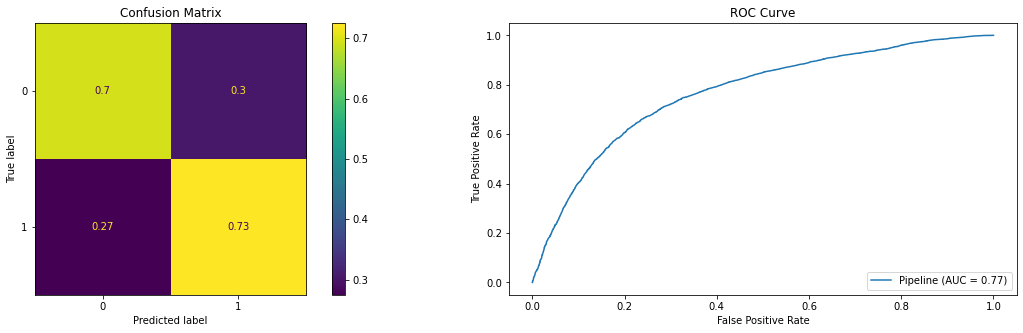

In [22]:
y_pred = fit.predict(X_test)
print(classification_report(y_test, y_pred))

fig = plt.figure(1, figsize=(20, 5))

chart_1 = fig.add_subplot(121)
chart_2 = fig.add_subplot(122)

# Pass Fitted Model, and our test sets, see how they do
plot_confusion_matrix(pipe1, X_test, y_test, normalize='true', ax=chart_1)
chart_1.set_title('Confusion Matrix')

plot_roc_curve(pipe1, X_test, y_test, ax=chart_2)
chart_2.set_title('ROC Curve')

plt.show()